#  TopSE 13期 ビッグデータIT基盤 課題レポート

In [222]:
#[分析目標]
#気象庁から取得できる過去の天気情報を元に天気予報（翌日、明後日）を実現

#[天気情報]
# http://www.data.jma.go.jp/gmd/risk/obsdl/
# →２００１年〜２０１６年の東京の気象データ(*.csv)を以下の場所に格納
 # (本ファイルのディレクトリ)/data4/*.csv

#[処理概要]
# (1) 分析に必要なライブラリをロード
# (2) 気象情報(*.csv) をデータフレームにロード
# (3) 気象情報を可視化
# (4)　説明変数と目的変数を決める
# (5)　正解ラベルを作成
# (6) 気象情報を学習データと評価データに分割
# (7) 学習モデルを作成
# (8) 翌日と明後日の気象情報を予測
# (9) 予測結果を評価    
    
#[備考]
# pandasライブラリの仕様上、各年度の気象データ（datasets/data4/*.csv）に対し
# 以下(1),(2)を実施すみ。
 
#(1) 元データの複数行に分散していた属性を結合し先頭行に配置
#(2) *.csv の文字コードをUTF-8 に変換（ "nkf" コマンドを使って変換）

### 分析結果サマリー
#### 翌日と明後日に東京降水量の合計(mm) が1mm以上 か否かを予測するシンプルな機械学習モデルを作成した。
#### このモデルに基づく予測精度は以下の通り。
#### 　翌日の予測精度（正解率）： 約71.7%
#### 　明後日の予測精度（正解率）： 約71.9%

## (1) 分析に必要なライブラリをロード

In [223]:
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## (2) 気象情報(*.csv) をデータフレームにロード

In [224]:
# 各年データを list_df[] に格納
list_csv = ['2001', '2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']
list_df = [] # 要素０〜13 に ２００１年〜２０１４年のデータを格納

#d = lambda x: pd.datetime.strptime(x, '%Y/%m/%d')

df= []
for i in range(len(list_csv)):
    list_df.append(pd.read_csv('./data4/' + list_csv[i] + '.csv', index_col='年月日', parse_dates=True))

#df_test = pd.read_csv('./data4/2001.csv', index_col='年月日', parse_dates=True)
    
# 全年（結合）データを df に格納
df = list_df[0]
for i in range(len(list_csv)-1) :
    df = pd.concat( [df, list_df[i+1]], join='inner' )

データが適切にロードされているかを、データ構造と異常値有無の観点で確認する。

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5844 entries, 2001-01-01 to 2016-12-31
Data columns (total 65 columns):
東京最高気温(℃)                  5844 non-null float64
東京最高気温(℃)品質情報              5844 non-null int64
東京最高気温(℃)均質番号              5844 non-null int64
東京最低気温(℃)                  5844 non-null float64
東京最低気温(℃)品質情報              5844 non-null int64
東京最低気温(℃)均質番号              5844 non-null int64
東京平均気温(℃)                  5844 non-null float64
東京平均気温(℃)品質情報              5844 non-null int64
東京平均気温(℃)均質番号              5844 non-null int64
東京降水量の合計(mm)               5844 non-null float64
東京降水量の合計(mm)現象なし情報         5844 non-null int64
東京降水量の合計(mm)品質情報           5844 non-null int64
東京降水量の合計(mm)均質番号           5844 non-null int64
東京日照時間(時間)                 5844 non-null float64
東京日照時間(時間)現象なし情報           5844 non-null int64
東京日照時間(時間)品質情報             5844 non-null int64
東京日照時間(時間)均質番号             5844 non-null int64
東京平均風速(m/s)                5837 non-null float64
東京平均風速(m/s)品質情報  

In [226]:
df.isnull().sum()

東京最高気温(℃)                  0
東京最高気温(℃)品質情報              0
東京最高気温(℃)均質番号              0
東京最低気温(℃)                  0
東京最低気温(℃)品質情報              0
東京最低気温(℃)均質番号              0
東京平均気温(℃)                  0
東京平均気温(℃)品質情報              0
東京平均気温(℃)均質番号              0
東京降水量の合計(mm)               0
東京降水量の合計(mm)現象なし情報         0
東京降水量の合計(mm)品質情報           0
東京降水量の合計(mm)均質番号           0
東京日照時間(時間)                 0
東京日照時間(時間)現象なし情報           0
東京日照時間(時間)品質情報             0
東京日照時間(時間)均質番号             0
東京平均風速(m/s)                7
東京平均風速(m/s)品質情報            0
東京平均風速(m/s)均質番号            0
東京最大風速(m/s)                0
東京最大風速(m/s)品質情報            0
東京最大風速(m/s).1              0
東京最大風速(m/s)品質情報.1          0
東京最大風速(m/s)均質番号            0
東京最大瞬間風速(m/s)              0
東京最大瞬間風速(m/s)品質情報          0
東京最大瞬間風速(m/s).1            0
東京最大瞬間風速(m/s)品質情報.1        0
東京最大瞬間風速(m/s)均質番号          0
                          ..
東京平均蒸気圧(hPa)均質番号           0
東京平均湿度(％)                  0
東京平均湿度(％)品質情報              0
東京平均湿度(％)均質番号 

目視確認レベルで、データは適切に取り込まれていると思われる。




## (3) 気象情報を可視化

In [227]:
df.describe()

,東京最高気温(℃),東京最高気温(℃)品質情報,東京最高気温(℃)均質番号,東京最低気温(℃),東京最低気温(℃)品質情報,東京最低気温(℃)均質番号,東京平均気温(℃),東京平均気温(℃)品質情報,東京平均気温(℃)均質番号,東京降水量の合計(mm),...,東京平均雲量(10分比)品質情報,東京平均雲量(10分比)均質番号,東京天気概況(昼：06時〜18時)品質情報,東京天気概況(昼：06時〜18時)均質番号,東京天気概況(夜：18時〜翌日06時)品質情報,東京天気概況(夜：18時〜翌日06時)均質番号,東京10分間降水量の最大(mm),東京10分間降水量の最大(mm)現象なし情報,東京10分間降水量の最大(mm)品質情報,東京10分間降水量の最大(mm)均質番号
count,5844.000000,5844.000000,5844.000000,5844.000000,5844.0,5844.000000,5844.000000,5844.0,5844.000000,5844.000000,...,5844.0,5844.0,5844.0,5844.0,5844.0,5844.0,5844.000000,5844.000000,5844.000000,5844.0
mean,20.472108,7.998973,1.005133,13.296920,8.0,1.005133,16.635917,8.0,1.005133,4.502738,...,8.0,1.0,8.0,1.0,8.0,1.0,0.644935,0.473477,7.999487,1.0
std,8.059217,0.055494,0.071470,8.133301,0.0,0.071470,7.907539,0.0,0.071470,13.626553,...,0.0,0.0,0.0,0.0,0.0,0.0,1.804388,0.499339,0.039243,0.0
min,1.800000,5.000000,1.000000,-2.600000,8.0,1.000000,0.300000,8.0,1.000000,0.000000,...,8.0,1.0,8.0,1.0,8.0,1.0,0.000000,0.000000,5.000000,1.0
25%,13.300000,8.000000,1.000000,5.700000,8.0,1.000000,9.400000,8.0,1.000000,0.000000,...,8.0,1.0,8.0,1.0,8.0,1.0,0.000000,0.000000,8.000000,1.0
50%,20.800000,8.000000,1.000000,13.600000,8.0,1.000000,17.200000,8.0,1.000000,0.000000,...,8.0,1.0,8.0,1.0,8.0,1.0,0.000000,0.000000,8.000000,1.0
75%,26.900000,8.000000,1.000000,20.100000,8.0,1.000000,23.100000,8.0,1.000000,1.500000,...,8.0,1.0,8.0,1.0,8.0,1.0,0.500000,1.000000,8.000000,1.0
max,39.500000,8.000000,2.000000,30.400000,8.0,2.000000,33.200000,8.0,2.000000,222.500000,...,8.0,1.0,8.0,1.0,8.0,1.0,22.500000,1.000000,8.000000,1.0


標準偏差や最小、最大値を見る限り、異常値は特になさそうに見えるので、この時点で異常値除去は考えない。

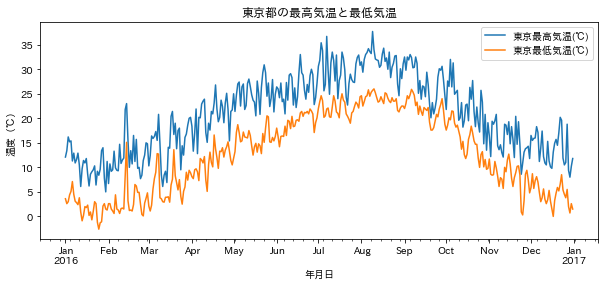

In [228]:
# まずは、最高気温と最低気温を可視化

year_min='2016'
year_max='2016'

ax1 = df[['東京最高気温(℃)', '東京最低気温(℃)'] ].loc[year_min:year_max].plot(legend=True,figsize=(10,4))
ax1.set_title('東京都の最高気温と最低気温')
ax1.set_ylabel('温度（℃）')
ax1.set_xlabel('年月日')
plt.show()


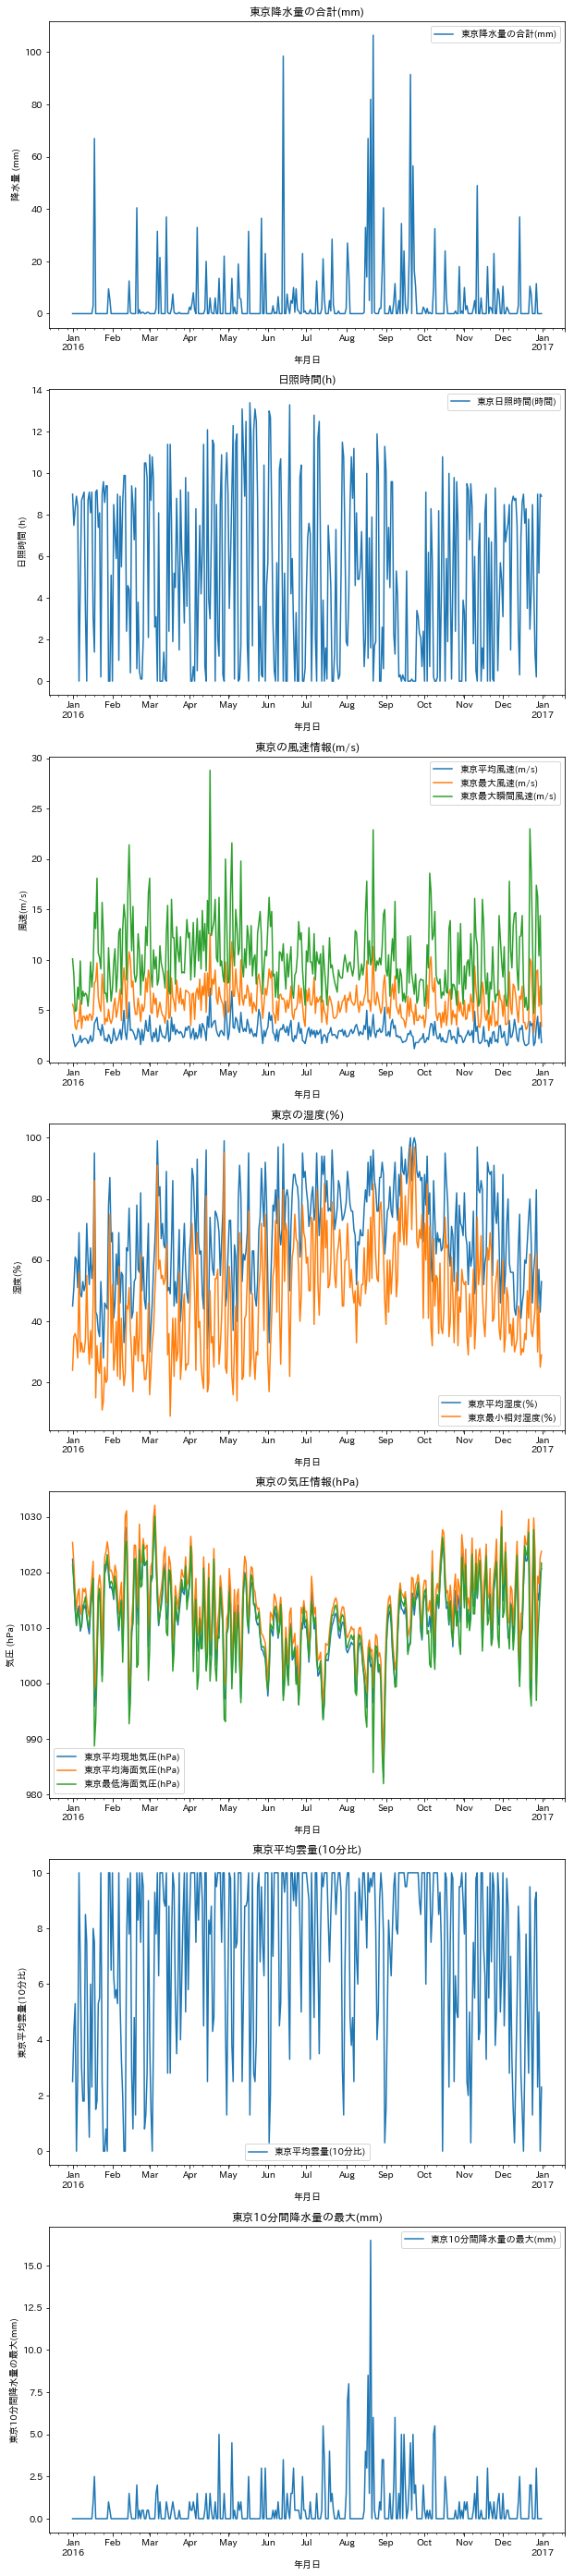

In [229]:
# 計数値を可視化

fig=plt.figure()

# subplot(a, b, c)  a行 b列 の c番目
ax1=fig.add_subplot(711)
ax2=fig.add_subplot(712)
ax3=fig.add_subplot(713)
ax4=fig.add_subplot(714)
ax5=fig.add_subplot(715)
ax6=fig.add_subplot(716)
ax7=fig.add_subplot(717)

year_min='2016'
year_max='2016'

figsz=(10,50)

df[['東京降水量の合計(mm)'] ].loc[year_min:year_max].plot(ax = ax1, legend = True, figsize = figsz, 
                           title = '東京降水量の合計(mm)' )
ax1.set_ylabel('降水量 (mm)')
                           
df[['東京日照時間(時間)'] ].loc[year_min:year_max].plot(ax = ax2, legend = True, figsize = figsz,
                          title = '日照時間(h)' )
ax2.set_ylabel('日照時間 (h)')

df[['東京平均風速(m/s)','東京最大風速(m/s)','東京最大瞬間風速(m/s)'] ].loc[year_min:year_max].plot(ax = ax3, legend = True, figsize = figsz,
                          title = '東京の風速情報(m/s)' )
ax3.set_ylabel('風速(m/s)')

df[['東京平均湿度(％)','東京最小相対湿度(％)'] ].loc[year_min:year_max].plot(ax = ax4, legend = True, figsize = figsz,
                          title = '東京の湿度(％)' )
ax4.set_ylabel('湿度(％)')

df[['東京平均現地気圧(hPa)','東京平均海面気圧(hPa)','東京最低海面気圧(hPa)'] ].loc[year_min:year_max].plot(ax = ax5, legend = True, figsize = figsz,
                          title = '東京の気圧情報(hPa)' )
ax5.set_ylabel('気圧 (hPa)')

df[['東京平均雲量(10分比)'] ].loc[year_min:year_max].plot(ax = ax6, legend = True, figsize = figsz,
                          title = '東京平均雲量(10分比)' )
ax6.set_ylabel('東京平均雲量(10分比)')

df[['東京10分間降水量の最大(mm)'] ].loc[year_min:year_max].plot(ax = ax7, legend = True, figsize = figsz,
                          title = '東京10分間降水量の最大(mm)' )
ax7.set_ylabel('東京10分間降水量の最大(mm)')

#plt.suptitle("各属性を時系列で見える化", size=16)
plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()

# Ref. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

### 目的変数候補（東京天気概況）の可視化
#### 昼と夜があるが、予測需要の高いと思われる「昼」に限定

In [230]:
df[['東京天気概況(昼：06時〜18時)'] ].describe()

,東京天気概況(昼：06時〜18時)
count,5844
unique,220
top,晴
freq,842


In [231]:
# カウント値を調べる
df['東京天気概況(昼：06時〜18時)'].value_counts(ascending=False)

晴                   842
快晴                  640
曇                   586
晴一時曇                236
曇後晴                 200
晴時々曇                186
曇一時晴                179
曇一時雨                175
曇時々雨                159
薄曇                  150
晴後一時曇               144
雨                   131
晴後曇                 130
曇時々晴                129
雨時々曇                123
曇後一時雨               118
曇後一時晴               117
曇後雨                 115
晴後薄曇                109
雨後曇                 102
晴後一時薄曇               99
雨一時曇                 83
晴時々薄曇                82
薄曇時々晴                67
薄曇一時晴                61
晴一時薄曇                57
大雨                   51
曇後時々雨                40
雨後一時曇                37
曇一時雨後晴               35
                   ... 
みぞれ時々雪後雨              1
大雨後薄曇、雷を伴う            1
曇時々雪、みぞれを伴う           1
雪後みぞれ                 1
曇後一時晴、雷を伴う            1
曇一時晴後雨、雷を伴う           1
晴後一時曇、雷を伴う            1
雨時々曇一時みぞれ、ひょうを伴う      1
曇後大雨一時晴               1
晴後時々曇一時雨、雷を伴う         1
雨後晴、あられを伴う      

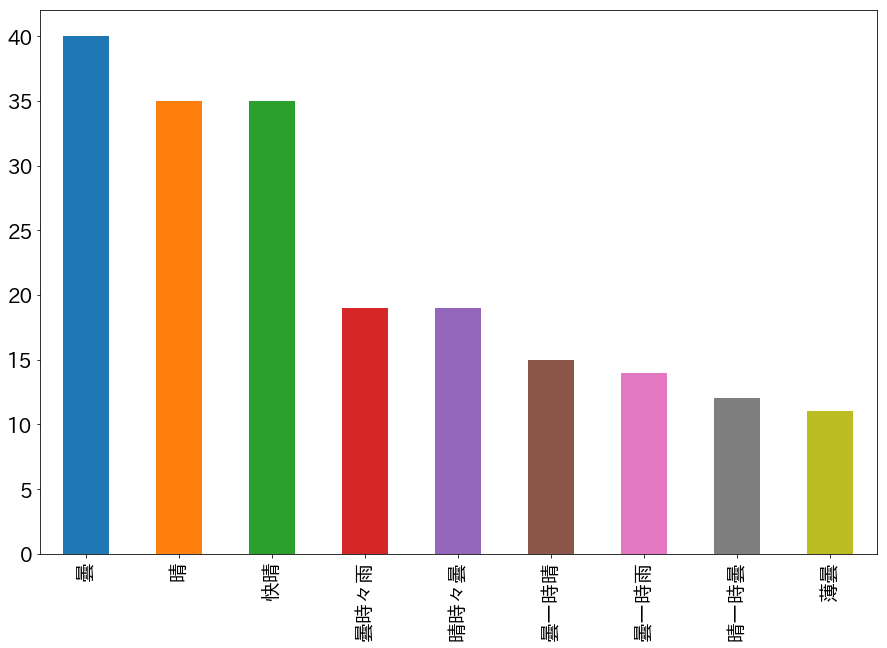

In [232]:
# グラフ化（カウント値のパターンが２００以上あり、このままではグラフ化しても見えづらいので
# カウント値が５０以上に限定して可視化

sf = df['東京天気概況(昼：06時〜18時)'].loc['2016':'2016'].value_counts(ascending=False)
sf = sf[sf > 10]
sf.plot(kind='bar', figsize=(15,10), fontsize=20)

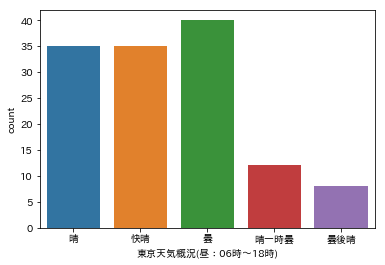

In [233]:
#【参考】 列の並び順を細かく調整したい場合は、以下の方法で可視化
sns.countplot('東京天気概況(昼：06時〜18時)',data=df.loc['2016':'2016'] , order=['晴','快晴','曇','晴一時曇','曇後晴'])

## (4) 説明変数と目的変数を決める


### 説明変数

In [234]:
#  「(3) 気象情報を可視化」 では、概ね、1年単位の季節変動（自己相関）が認められる。 
#　　本来であれば、説明変数間に交互作用が無いか、多重共線性が無いかなど、
#　　統計的な考察が必要であるが、機械学習による予測値を定量的に出すことを優先し
#　　以下の項目を説明変数とする。なお、　東京平均風速(m/s)は欠損値が存在するため説明変数から除外した。 
#
#　　【説明変数】
# 　　　東京最高気温(℃)  
#　　　　東京最低気温(℃) 
#　　　　東京平均気温(℃)  
#　　　　東京日照時間(時間)
#　　　　東京最大風速(m/s) 
#　　　　東京最大瞬間風速(m/s) 
#　　　　東京平均湿度(％) 
#　　　　東京最小相対湿度(％)
#　　　　東京平均現地気圧(hPa) 
#　　　　東京平均海面気圧(hPa)
#　　　　東京最低海面気圧(hPa) 
#　　　　東京平均雲量(10分比) 
#　　　　

### 目的変数

In [235]:
#　　東京降水量の合計(mm) を目的変数にする。
#  具体的には、東京降水量の合計が1mm/day以上あった日を1、なかった日を0にする
#   変数を追加し、これを目的変数にする。

# 【補足】
#  当初は東京天気概況(昼：06時〜18時) を目的変数の第一候補に考えていたが、
#  現実的数（せいぜい１０パターン）をはるかに超える約２００パターンあることがわかった。
#  よって、「東京降水量の合計(mm)」を２値化したものを目的変数とした。

## (5) 正解ラベルを作成


In [236]:
# 翌日、明後日の降水量が 1mm以上を「１」、それ以外は「０」の目的変数（＝正解ラベル）を作成する。
y_1day_label = []
y_2day_label = []
for i in range(len(df)-2 ):
    y_1day_label.append(0 if df['東京降水量の合計(mm)'][i + 1] < 1. else 1)
    y_2day_label.append(0 if df['東京降水量の合計(mm)'][i + 2] < 1. else 1)
df_1day_label = pd.DataFrame({'label': y_1day_label})
df_2day_label = pd.DataFrame({'label': y_2day_label})


## (6) 気象情報を学習データと評価データに分割


In [237]:
# 気象情報（説明変数として使う列のみ抽出したデータフレームを作成）
# 　（翌々日の正解ラベルを作成したため、末尾の２行分を削除）
features = df.iloc[:-2, df.columns.isin(['東京最高気温(℃)', '東京最低気温(℃)', '東京平均気温(℃)', 
                                      '東京日照時間(時間)',
                                      '東京最大風速(m/s)', '東京最大瞬間風速(m/s)', '東京平均湿度(％)' ,
                                      '東京最小相対湿度(％)', '東京平均現地気圧(hPa)', '東京平均海面気圧(hPa)', 
                                      '東京最低海面気圧(hPa)', '東京平均雲量(10分比)'
                                     ])]


In [238]:
# 学習データと評価データを作成
X_train_1day, X_test_1day, Y_train_1day, Y_test_1day = train_test_split(features, 
                                                                        df_1day_label, test_size=0.3 ,random_state=10, shuffle=False)

X_train_2day, X_test_2day, Y_train_2day, Y_test_2day = train_test_split(features, 
                                                                        df_2day_label, test_size=0.3 ,random_state=10, shuffle=False)


## (7) 学習モデルを作成

In [239]:
# 学習モデルを作成
lr_1day = LogisticRegression().fit(X_train_1day, Y_train_1day)
lr_2day = LogisticRegression().fit(X_train_2day, Y_train_2day)

/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## (8) 翌日と明後日の気象情報を予測


In [240]:
# 翌日に　1mm以上の雨が降るかどうかの正解率
cross_val_score(lr_1day, features, df_1day_label, cv=5).mean()


/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

0.716534653892352

In [241]:
# 明後日に　1mm以上の雨が降るかどうかの正解率
cross_val_score(lr_2day, features, df_2day_label, cv=5).mean()

/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/mkkrf/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

0.7185895974013168

## (9) 予測結果を評価


#### 翌日に1mm以上の雨が降るかどうかの正解率は約71.7% となった。
#### 明後日に1mm以上の雨が降るかどうかの正解率は約71.9% となった。